In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings("ignore")

In [32]:
with open('file_name.pkl', 'rb') as handle:
    df = pickle.load(handle)
    

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   layer_height              69 non-null     float64
 1   wall_thickness            69 non-null     float64
 2   infill_density            69 non-null     float64
 3   nozzle_temperature        69 non-null     float64
 4   bed_temperature           69 non-null     float64
 5   print_speed               69 non-null     float64
 6   fan_speed                 69 non-null     float64
 7   roughness                 69 non-null     float64
 8   tension_strength          69 non-null     float64
 9   elongation                69 non-null     float64
 10  infill_pattern_honeycomb  69 non-null     uint8  
 11  material_pla              69 non-null     uint8  
dtypes: float64(10), uint8(2)
memory usage: 5.7 KB


In [42]:
from sklearn.model_selection import train_test_split

df_regression = df.drop(['roughness', 'elongation'], axis=1)
X = df_regression.drop('tension_strength', axis=1)
y = df_regression['tension_strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [75]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, DMatrix, train
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score

In [76]:
linreg = LinearRegression()
xgb = XGBRegressor()
mlpr = MLPRegressor(solver='adam', activation='relu')

regression_models = [[linreg, 'Linear Regression'],
                    [xgb, 'XGBoost Regressor'],
                    [mlpr, 'MLP Regressor']]  #MLPRegressor - multi-layer perceptron regressor


def regression_model(model_r):
    regressor = model_r
    regressor.fit(X_train, y_train)
    Y_pred_reg = regressor.predict(X_test)
    score_r2 = r2_score(y_test, Y_pred_reg)
    print(score_r2)

In [77]:
for i,j in regression_models:
    regression_model(i)
    print(f'Training Data Accuracy for the model {j}:{i.score(X_train, y_train)}')
    print(f'Test Data Accuracy for the model {j}: {i.score(X_test, y_test)}')
    print('\n')

-0.029570484368323324
Training Data Accuracy for the model Linear Regression:0.5234232934974358
Test Data Accuracy for the model Linear Regression: -0.029570484368323324


0.0007892761187008324
Training Data Accuracy for the model XGBoost Regressor:0.9999983393854266
Test Data Accuracy for the model XGBoost Regressor: 0.0007892761187008324


0.3195133547143473
Training Data Accuracy for the model MLP Regressor:0.9301328830602786
Test Data Accuracy for the model MLP Regressor: 0.3195133547143473




In [109]:
xgb_1 = XGBRegressor(objective='reg:squarederror', n_estimators=50)
xgb_1.fit(X_train, y_train)
y_pred_xgb_1 = xgb_1.predict(X_test)
print(f'Training Data Accuracy for the model xgb_1:{xgb_1.score(X_train, y_train)}')
print(f'Test Data Accuracy for the xgb_1: {xgb_1.score(X_test, y_test)}')
print(f'Mean Sqaured Error for the model xgb_1: {mean_squared_error(y_test, y_pred_xgb_1)}')

Training Data Accuracy for the model xgb_1:0.9999983392765985
Test Data Accuracy for the xgb_1: 0.0007848838551243187
Mean Sqaured Error for the model xgb_1: 0.49241325823992377


In [96]:
dm_train = DMatrix(data=X_train, label=y_train)
dm_test = DMatrix(data=X_test, label=y_test)
params = {'booster':'gblinear', 'ojective':'reg:squarederror'}

xgb_2 = train(params = params, dtrain=dm_train, num_boost_round=5)
y_pred_xgb_2 = xgb_2.predict(dm_test)

rmse = np.sqrt(mean_squared_error(y_test,y_pred_xgb_2))
print("RMSE: %f" % (rmse))

RMSE: 0.599586


In [118]:
xgb_3 = XGBRegressor(objective='reg:squarederror', booster='dart', n_estimators=50)
xgb_3.fit(X_train, y_train)
y_pred_xgb_3 = xgb_1.predict(X_test)

print(f'Training Data Accuracy for the model xgb_1:{xgb_3.score(X_train, y_train)}')
print(f'Test Data Accuracy for the xgb_1: {xgb_3.score(X_test, y_test)}')
print(f'Mean Sqaured Error for the model xgb_1: {mean_squared_error(y_test, y_pred_xgb_3)}')

Training Data Accuracy for the model xgb_1:0.9999983393103027
Test Data Accuracy for the xgb_1: 0.0007848124903564457
Mean Sqaured Error for the model xgb_1: 0.49241325823992377


In [116]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 800x700 with 0 Axes>

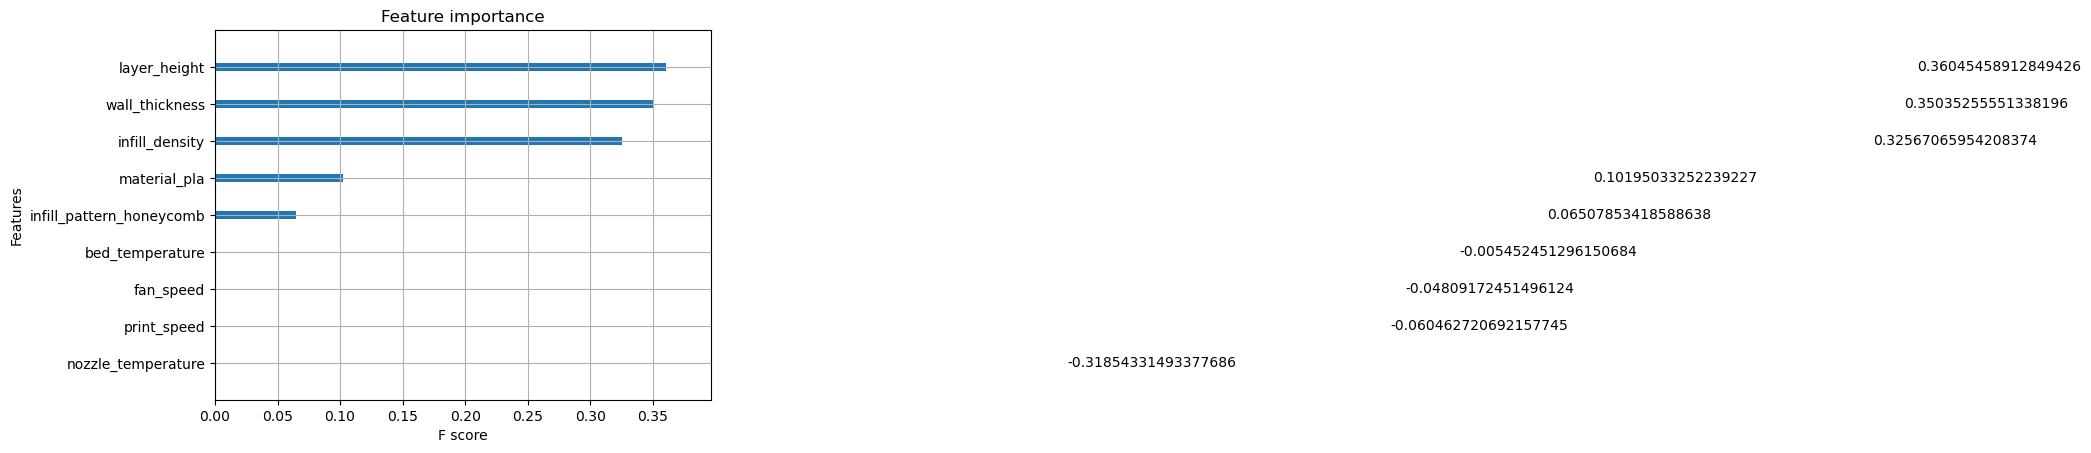

In [113]:
plt.figure(figsize=(8,7))
xgb.plot_importance(booster=xgb_2)

In [136]:
parameter_grid = {'booster':['gblinear', 'gbtree'],
                  'eta':[0.001, 0.01, 0.1],
                 'max_depth':np.arange(2,11,1),
                 'gamma':[1, 2, 3]}

gsc = GridSearchCV(estimator=XGBRegressor(n_estimators=4, num_boost_rounds=5),
                  param_grid=parameter_grid,
                  scoring='neg_mean_squared_error',
                  cv=3,
                  verbose=1)

gsc.fit(X_train, y_train)

print(f'best score: {gsc.best_score_}')
print(f'best parameters: {gsc.best_params_}')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
best score: -0.792359110740255
best parameters: {'booster': 'gbtree', 'eta': 0.1, 'gamma': 1, 'max_depth': 6}


In [137]:
y_pred_best = gsc.best_estimator_.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'Best model RMSE on test set: {rmse_best}')

Best model RMSE on test set: 0.8770636432287333


In [138]:
xgb_k = XGBRegressor(booster='gbtree', eta=0.1, gamma=1, max_depth=6, n_estimators=4, num_boost_round=5)
xgb_k.fit(X_train, y_train)
y_pred_xgb_k = xgb_k.predict(X_test)

print(f'Training Data Accuracy for the model xgb_k:{xgb_k.score(X_train, y_train)}')
print(f'Test Data Accuracy for the xgb_k: {xgb_k.score(X_test, y_test)}')
print(f'Mean Sqaured Error for the model xgb_k: {mean_squared_error(y_test, y_pred_xgb_k)}')

Training Data Accuracy for the model xgb_k:0.4059074582726089
Test Data Accuracy for the xgb_k: -0.5609589239463586
Mean Sqaured Error for the model xgb_k: 0.7692406342736587
